<a href="https://colab.research.google.com/github/ipanditi/ML/blob/main/Enhanced_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
population = pd.DataFrame(pd.read_excel("population-data.xlsx"))
population.head()

year clinic name  age-group  population-count
0  2020    Klinik F          1               776
1  2020    Klinik F          2              1712
2  2020    Klinik F          3              1932
3  2020    Klinik F          4              1928
4  2020    Klinik F          5              1947

In [4]:
virtualclinic = pd.DataFrame(pd.read_excel("virtual_clinic_extract.xlsx"))
virtualclinic.head()

case-number clinic name  year  age-group  \
0  3e7f19fe-7bad-41f2-8d3b-504d6eaf9b12    Klinik A  2018         16   
1  89333820-613c-474c-b129-43ffe7619175    Klinik A  2018         17   
2  e54b0e3e-f691-4552-a17f-e6b42a7efe5b    Klinik A  2018         13   
3  52878d9b-4e1d-4f1c-9f5e-2a390f05ed39    Klinik A  2018         19   
4  2b07e9ed-58ac-4ab5-a9ad-f1a687ea234e    Klinik A  2018         17   

  icd main-diagnosis  length of stay in days        inlier-type  \
0                I63                    50.0  OUTLIER_LONG_STAY   
1                I63                    13.2             INLIER   
2                I63                     9.3             INLIER   
3                I63                     9.8             INLIER   
4                I63                    12.5             INLIER   

  admission-date admission-time  \
0     2018-05-29          15:01   
1     2018-04-28          07:27   
2     2018-10-02          08:47   
3     2018-08-27          18:02   
4     2018-10-20          22:08   

                                 secondary-diagnoses  \
0  G81.0 | R47.1 | E11.91 | E11.90 | I11.90 | R39...   
1  Z85.5 | R26.0 | I70.21 | H53.2 | I65.1 | G83.1...   
2     G81.0 | H34.1 | I65.2 | Z88.0 | R47.1 | I11.91   
3  G81.0 | U50.20 | I65.2 | I11.90 | F10.1 | F10....   
4  G81.0 | I63.4 | I65.2 | I66.2 | U50.50 | E05.8...   

                                          procedures  
0  8-981.1#2018-05-29T15:01 | 1-207.0#2018-05-30T...  
1  3-220#2018-04-28T07:27 | 8-981.1#2018-04-28T07...  
2  8-981.1#2018-10-02T08:47 | 3-200#2018-10-02T08...  
3  8-981.1#2018-08-27T18:02 | 3-200#2018-08-27T18...  
4  3-200#2018-10-20T22:08 | 3-220#2018-10-22T08:3...

In [5]:
icd_codes = pd.DataFrame(pd.read_excel("icd_codes.xlsx"))
icd_codes.head()

icd main-diagnosis             description    block chapter
0              A51.5    Latente Frühsyphilis  A50-A64       I
1              B26.0    Mumps-Orchitis N51.1  B25-B34       I
2              B26.1  Mumps-Meningitis G02.0  B25-B34       I
3              B66.3            Fascioliasis  B65-B83       I
4              B66.4          Paragonimiasis  B65-B83       I

In [6]:
cases_admin = pd.DataFrame(pd.read_excel("cases-administrative-district-ids.xlsx"))
cases_admin.head()

clinic name  year  age-group icd main-diagnosis  case sum
0    Klinik B  2018         16                I65         6
1    Klinik B  2019         17                I63        83
2    Klinik B  2019          1                I63         2
3    Klinik B  2020         12                I61         3
4    Klinik B  2019         16                I63        63

In [7]:
ops_codes = pd.DataFrame(pd.read_excel("ops_codes.xlsx"))
ops_codes.head()

code                                description block  chapter
0    1                   DIAGNOSTISCHE MASSNAHMEN   NaN      NaN
1    3                     BILDGEBENDE DIAGNOSTIK   NaN      NaN
2    5                                OPERATIONEN   NaN      NaN
3    6                                MEDIKAMENTE   NaN      NaN
4    8  NICHT OPERATIVE THERAPEUTISCHE MASSNAHMEN   NaN      NaN

In [8]:
first = population.merge(virtualclinic, on = ['clinic name','year','age-group'] )
first.head()

year clinic name  age-group  population-count  \
0  2020    Klinik F          7              2639   
1  2020    Klinik F          8              2601   
2  2020    Klinik F         10              2608   
3  2020    Klinik F         10              2608   
4  2020    Klinik F         11              2496   

                            case-number icd main-diagnosis  \
0  d9de21ff-abff-4b09-b8ec-3be5224ef0fb                I63   
1  39ddd12c-4194-48c1-b7df-f1de35999957                I63   
2  73b40343-4fc7-43db-998f-ad0224e16dd1                I60   
3  3e1cb8b3-6fab-465c-b184-d8bfcd2e49fd                I63   
4  6acc6387-2d41-4ab3-aa73-52e8870119ed                I61   

   length of stay in days        inlier-type admission-date admission-time  \
0                     2.9             INLIER     2020-05-10          11:01   
1                    11.9             INLIER     2020-05-10          17:11   
2                     0.1  OUTLIER_LONG_STAY     2020-07-20          19:03   
3                     2.9             INLIER     2020-10-05          12:27   
4                     3.9             INLIER     2020-06-15          16:31   

                                 secondary-diagnoses  \
0       G81.0 | U50.10 | G43.0 | E78.0 | F17.1 | R51   
1     G81.0 | H53.4 | U50.40 | R20.1 | R47.0 | E78.0   
2                                              I46.0   
3  G81.0 | U51.00 | U50.00 | I67.10 | G43.0 | R20...   
4             U51.10 | H53.4 | G40.2 | R47.0 | F06.0   

                                          procedures  
0  1-204.2#2020-05-10T11:01 | 8-981.0#2020-05-10T...  
1  8-020.8#2020-05-10T17:11 | 8-981.1#2020-05-10T...  
2  8-930#2020-07-20T19:03 | 3-225#2020-07-20T20:2...  
3  8-981.0#2020-10-05T12:27 | 3-200#2020-10-05T13...  
4  8-981.1#2020-06-15T16:31 | 3-221#2020-06-15T18...

In [9]:
df = first.merge(cases_admin, on = ['clinic name','year','icd main-diagnosis','age-group'] )
df.head()

year clinic name  age-group  population-count  \
0  2020    Klinik F         10              2608   
1  2020    Klinik F         11              2496   
2  2020    Klinik F         11              2496   
3  2020    Klinik F         12              3616   
4  2020    Klinik F         12              3616   

                            case-number icd main-diagnosis  \
0  73b40343-4fc7-43db-998f-ad0224e16dd1                I60   
1  d36a19db-d8a8-4f6e-8bac-ad788f25ac15                I63   
2  99f65b8b-04ca-498c-850b-a913b5e948b9                I63   
3  0733b0b2-0535-4235-a2ce-832697572036                I63   
4  1cf3ac08-64fb-430e-99cc-336ddb03d5bb                I63   

   length of stay in days        inlier-type admission-date admission-time  \
0                     0.1  OUTLIER_LONG_STAY     2020-07-20          19:03   
1                     0.1  OUTLIER_LONG_STAY     2020-09-25          17:36   
2                     2.9             INLIER     2020-11-17          22:33   
3                     9.8             INLIER     2020-05-03          14:53   
4                    18.9             INLIER     2020-05-01          19:41   

                                 secondary-diagnoses  \
0                                              I46.0   
1  G81.0 | H53.4 | R47.1 | U51.20 | E66.99 | R29....   
2  G81.0 | U51.00 | R26.0 | R47.1 | U50.00 | R20....   
3  G81.0 | G93.0 | R27.0 | R26.0 | R47.1 | H55 | ...   
4  D62 | R27.0 | R47.1 | R63.3 | I48.1 | R00.1 | ...   

                                          procedures  case sum  
0  8-930#2020-07-20T19:03 | 3-225#2020-07-20T20:2...         1  
1  8-020.8#2020-09-25T17:36 | 3-220#2020-09-25T18...         5  
2  8-981.0#2020-11-17T22:33 | 3-221#2020-11-17T23...         5  
3  3-221#2020-05-03T16:51 | 3-228#2020-05-03T16:5...        10  
4  8-930#2020-05-02T09:59 | 3-221#2020-05-02T11:0...        10

In [18]:
df.describe()

year    age-group  population-count  length of stay in days  \
count  5765.000000  5765.000000       5765.000000             5765.000000   
mean   2018.939115    16.105811      14607.227060                9.140087   
std       0.824633     2.590870      10030.540023                8.313027   
min    2018.000000     6.000000        137.000000                0.000000   
25%    2018.000000    14.000000       6884.000000                3.900000   
50%    2019.000000    17.000000      11576.000000                6.800000   
75%    2020.000000    18.000000      20979.000000               11.900000   
max    2020.000000    20.000000      41911.000000              107.000000   

          case sum  
count  5765.000000  
mean     85.693495  
std      71.016779  
min       1.000000  
25%      27.000000  
50%      70.000000  
75%     124.000000  
max     273.000000

In [19]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

secondary-diagnoses  year  clinic name  age-group  population-count  \
Total              27.000000   0.0          0.0        0.0               0.0   
Percent             0.468343   0.0          0.0        0.0               0.0   

         case-number  icd main-diagnosis  length of stay in days  inlier-type  \
Total            0.0                 0.0                     0.0          0.0   
Percent          0.0                 0.0                     0.0          0.0   

         admission-date  admission-time  procedures  case sum  
Total               0.0             0.0         0.0       0.0  
Percent             0.0             0.0         0.0       0.0

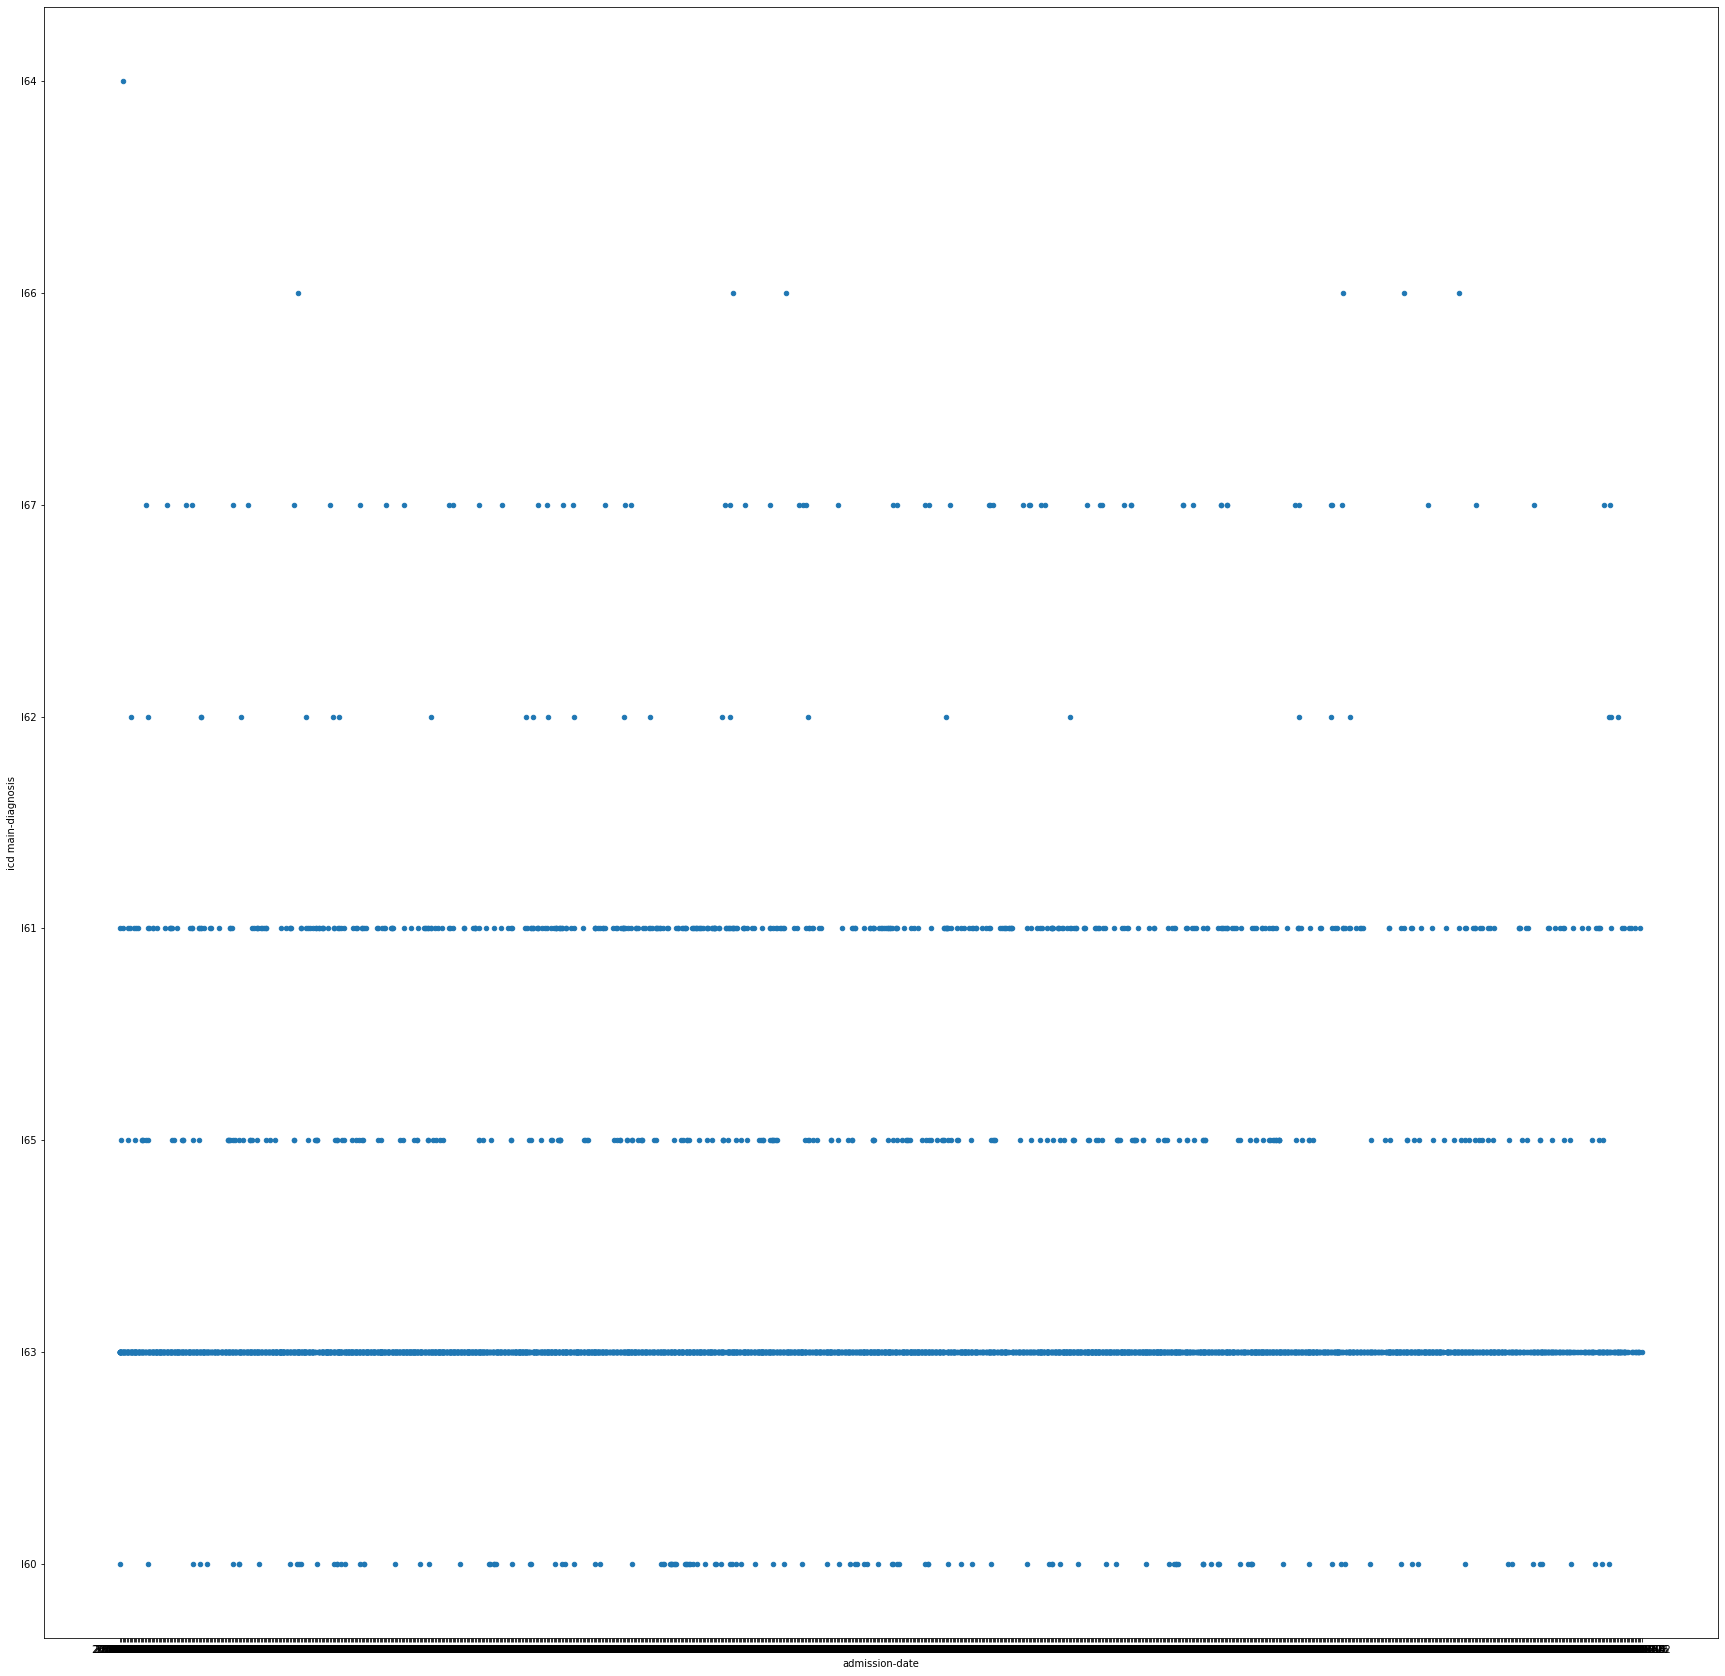

In [20]:
df.plot.scatter(x= 'admission-date', y='icd main-diagnosis',figsize=(30,30))

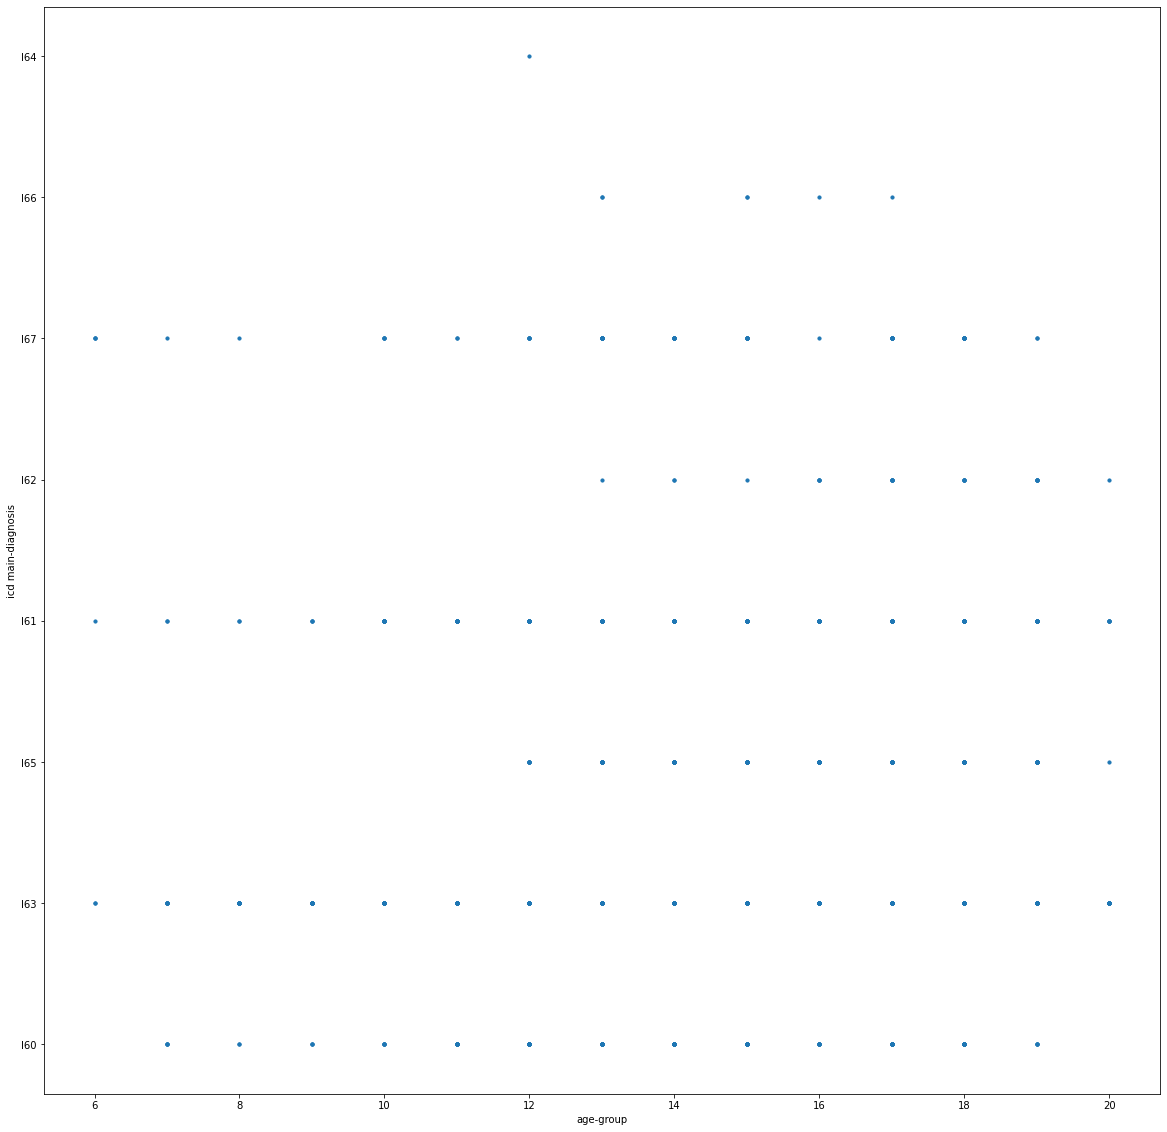

In [21]:
df.plot.scatter(x='age-group',y='icd main-diagnosis',figsize=(20,20), s=10 )

In [22]:
df1 = df['icd main-diagnosis'].value_counts()
print(df1)

I63    4845
I61     438
I65     249
I60     134
I67      66
I62      26
I66       6
I64       1
Name: icd main-diagnosis, dtype: int64


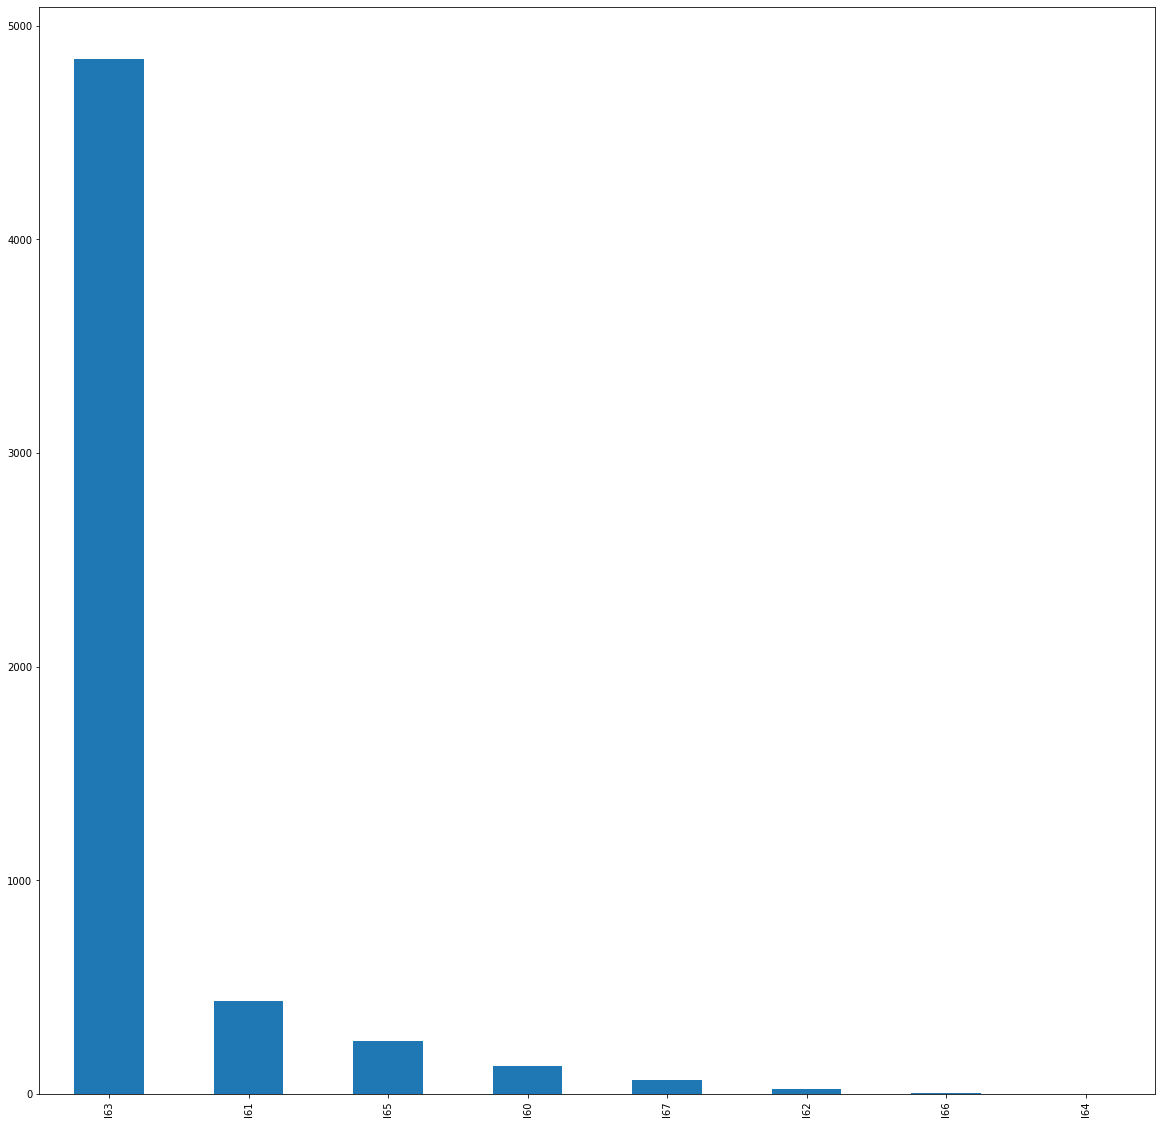

In [23]:
df['icd main-diagnosis'].value_counts().plot.bar(figsize=(20,20))

In [24]:
print(df.nunique())

year                         3
clinic name                  8
age-group                   15
population-count           225
case-number               5765
icd main-diagnosis           8
length of stay in days     394
inlier-type                  3
admission-date            1103
admission-time            1231
secondary-diagnoses       5624
procedures                5701
case sum                   101
dtype: int64


In [25]:
data = df.merge(icd_codes, on = 'icd main-diagnosis' )
data.head()

year clinic name  age-group  population-count  \
0  2020    Klinik F         10              2608   
1  2018    Klinik F         13              3628   
2  2018    Klinik F         18              2303   
3  2019    Klinik F         13              3289   
4  2019    Klinik F         14              3168   

                            case-number icd main-diagnosis  \
0  73b40343-4fc7-43db-998f-ad0224e16dd1                I60   
1  c54c71a2-8472-434f-a04d-fc01d077f200                I60   
2  6d801271-9468-43dd-bcda-77eb776de286                I60   
3  85d3ba12-ceaf-40ae-91db-e6925105e71f                I60   
4  05baa17b-6544-4025-8667-de601884a78b                I60   

   length of stay in days        inlier-type admission-date admission-time  \
0                     0.1  OUTLIER_LONG_STAY     2020-07-20          19:03   
1                     0.3  OUTLIER_LONG_STAY     2018-03-23          12:17   
2                     0.5  OUTLIER_LONG_STAY     2018-11-02          08:36   
3                     0.4  OUTLIER_LONG_STAY     2019-10-10          13:43   
4                     0.2  OUTLIER_LONG_STAY     2019-11-13          14:50   

                                 secondary-diagnoses  \
0                                              I46.0   
1  I72.8 | U51.00 | E87.1 | R27.0 | R11 | F10.1 |...   
2  I67.88 | U51.00 | I72.0 | R40.2 | Z92.2 | G45....   
3  E11.20 | U51.00 | U51.10 | E66.92 | I72.5 | U5...   
4                                                NaN   

                                          procedures  case sum  \
0  8-930#2020-07-20T19:03 | 3-225#2020-07-20T20:2...         1   
1  3-200#2018-03-23T13:48 | 3-990#2018-03-23T15:2...         2   
2  3-993#2018-11-02T11:30 | 1-204.2#2018-11-02T11...         1   
3  3-203#2019-10-10T14:53 | 3-200#2019-10-10T14:5...         2   
4  8-831.0#2019-11-13T14:50 | 8-931.0#2019-11-13T...         1   

             description    block chapter  
0  Subarachnoidalblutung  I60-I69      IX  
1  Subarachnoidalblutung  I60-I69      IX  
2  Subarachnoidalblutung  I60-I69      IX  
3  Subarachnoidalblutung  I60-I69      IX  
4  Subarachnoidalblutung  I60-I69      IX

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5765 entries, 0 to 5764
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    5765 non-null   int64  
 1   clinic name             5765 non-null   object 
 2   age-group               5765 non-null   int64  
 3   population-count        5765 non-null   int64  
 4   case-number             5765 non-null   object 
 5   icd main-diagnosis      5765 non-null   object 
 6   length of stay in days  5765 non-null   float64
 7   inlier-type             5765 non-null   object 
 8   admission-date          5765 non-null   object 
 9   admission-time          5765 non-null   object 
 10  secondary-diagnoses     5738 non-null   object 
 11  procedures              5765 non-null   object 
 12  case sum                5765 non-null   int64  
 13  description             5765 non-null   object 
 14  block                   5765 non-null   

In [27]:
data.describe()

year    age-group  population-count  length of stay in days  \
count  5765.000000  5765.000000       5765.000000             5765.000000   
mean   2018.939115    16.105811      14607.227060                9.140087   
std       0.824633     2.590870      10030.540023                8.313027   
min    2018.000000     6.000000        137.000000                0.000000   
25%    2018.000000    14.000000       6884.000000                3.900000   
50%    2019.000000    17.000000      11576.000000                6.800000   
75%    2020.000000    18.000000      20979.000000               11.900000   
max    2020.000000    20.000000      41911.000000              107.000000   

          case sum  
count  5765.000000  
mean     85.693495  
std      71.016779  
min       1.000000  
25%      27.000000  
50%      70.000000  
75%     124.000000  
max     273.000000

In [28]:
df=data.groupby(['clinic name','admission-date'])['case sum'].sum() \
            .groupby(['clinic name']).max().sort_values() \
            .groupby(['clinic name']).sum().sort_values(ascending = False)

#df.head(10)

top10 = pd.DataFrame(df).head(10)
top10

case sum
clinic name          
Klinik G         1715
Klinik A          743
Klinik B          551
Klinik E          326
Klinik D          311
Klinik H          149
Klinik C           91
Klinik F           82

In [29]:
df_by_date = pd.DataFrame(data.groupby(['clinic name','admission-date'])['case sum'].sum().sort_values().reset_index())
df_by_date

clinic name admission-date  case sum
0       Klinik B     2020-06-18         1
1       Klinik F     2018-09-08         1
2       Klinik B     2018-09-27         1
3       Klinik C     2018-08-18         1
4       Klinik B     2020-12-13         1
...          ...            ...       ...
3250    Klinik G     2019-09-13      1240
3251    Klinik G     2018-04-24      1296
3252    Klinik G     2018-04-03      1453
3253    Klinik G     2018-02-01      1476
3254    Klinik G     2018-01-24      1715

[3255 rows x 3 columns]

In [30]:
cat_feat = ['case-number','inlier-type','secondary-diagnoses','procedures', 'description', 'inlier-type','block','chapter']
final = data.drop(cat_feat, axis=1 )

In [31]:
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

In [32]:
final.head()

year clinic name  age-group  population-count icd main-diagnosis  \
0  2020    Klinik F         10              2608                I60   
1  2018    Klinik F         13              3628                I60   
2  2018    Klinik F         18              2303                I60   
3  2019    Klinik F         13              3289                I60   
4  2019    Klinik F         14              3168                I60   

   length of stay in days admission-date admission-time  case sum  
0                     0.1     2020-07-20          19:03         1  
1                     0.3     2018-03-23          12:17         2  
2                     0.5     2018-11-02          08:36         1  
3                     0.4     2019-10-10          13:43         2  
4                     0.2     2019-11-13          14:50         1

In [33]:
final = final[['admission-date', 'year', 'clinic name', 'age-group', 'population-count', 'case sum', 'icd main-diagnosis', 'length of stay in days', 'admission-time']]

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
final.head()

admission-date  year clinic name  age-group  population-count  case sum  \
0     2020-07-20  2020    Klinik F         10              2608         1   
1     2018-03-23  2018    Klinik F         13              3628         2   
2     2018-11-02  2018    Klinik F         18              2303         1   
3     2019-10-10  2019    Klinik F         13              3289         2   
4     2019-11-13  2019    Klinik F         14              3168         1   

  icd main-diagnosis  length of stay in days admission-time  
0                I60                     0.1          19:03  
1                I60                     0.3          12:17  
2                I60                     0.5          08:36  
3                I60                     0.4          13:43  
4                I60                     0.2          14:50

In [36]:
le = LabelEncoder()
final.iloc[:,8] = le.fit_transform(final.iloc[:,8])
final.head()

admission-date  year clinic name  age-group  population-count  case sum  \
0     2020-07-20  2020    Klinik F         10              2608         1   
1     2018-03-23  2018    Klinik F         13              3628         2   
2     2018-11-02  2018    Klinik F         18              2303         1   
3     2019-10-10  2019    Klinik F         13              3289         2   
4     2019-11-13  2019    Klinik F         14              3168         1   

  icd main-diagnosis  length of stay in days  admission-time  
0                I60                     0.1             962  
1                I60                     0.3             562  
2                I60                     0.5             341  
3                I60                     0.4             648  
4                I60                     0.2             714

In [37]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5765 entries, 0 to 5764
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   admission-date          5765 non-null   object 
 1   year                    5765 non-null   int64  
 2   clinic name             5765 non-null   object 
 3   age-group               5765 non-null   int64  
 4   population-count        5765 non-null   int64  
 5   case sum                5765 non-null   int64  
 6   icd main-diagnosis      5765 non-null   object 
 7   length of stay in days  5765 non-null   float64
 8   admission-time          5765 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 450.4+ KB


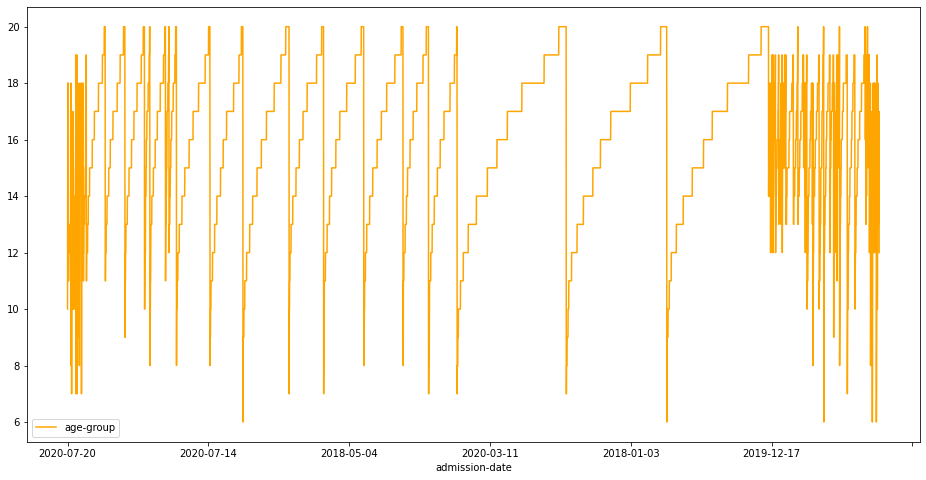

In [44]:
final.plot(x='admission-date', y='age-group',figsize=(16,8), color= 'orange')

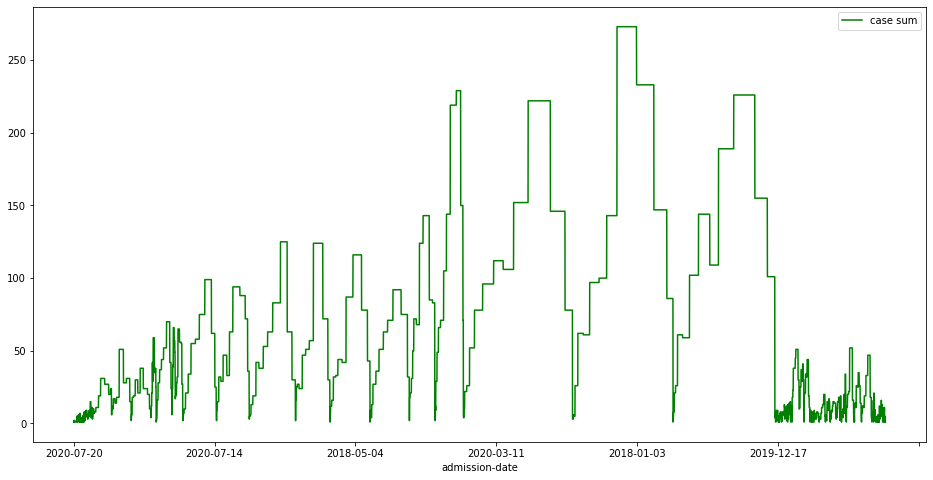

In [45]:
final.plot(x='admission-date', y='case sum',figsize=(16,8), color='green')

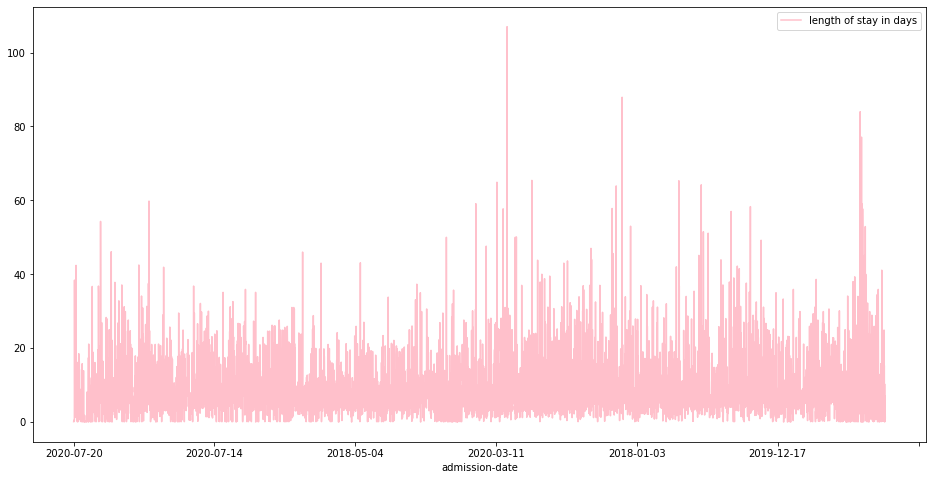

In [47]:
final.plot(x='admission-date', y='length of stay in days',figsize=(16,8), color='pink')

In [52]:
X = final[['admission-date','year','clinic name','age-group','population-count','case sum','length of stay in days','admission-time']]
y = final['case sum']

In [66]:
train_final = pd.DataFrame()
train_final['ds'] = pd.to_datetime(X["admission-date"])
train_final['y'] = y
train_final

ds  y
0    2020-07-20  1
1    2018-03-23  2
2    2018-11-02  1
3    2019-10-10  2
4    2019-11-13  1
...         ... ..
5760 2020-07-08  1
5761 2018-01-19  3
5762 2018-09-05  5
5763 2019-01-28  2
5764 2020-11-17  1

[5765 rows x 2 columns]

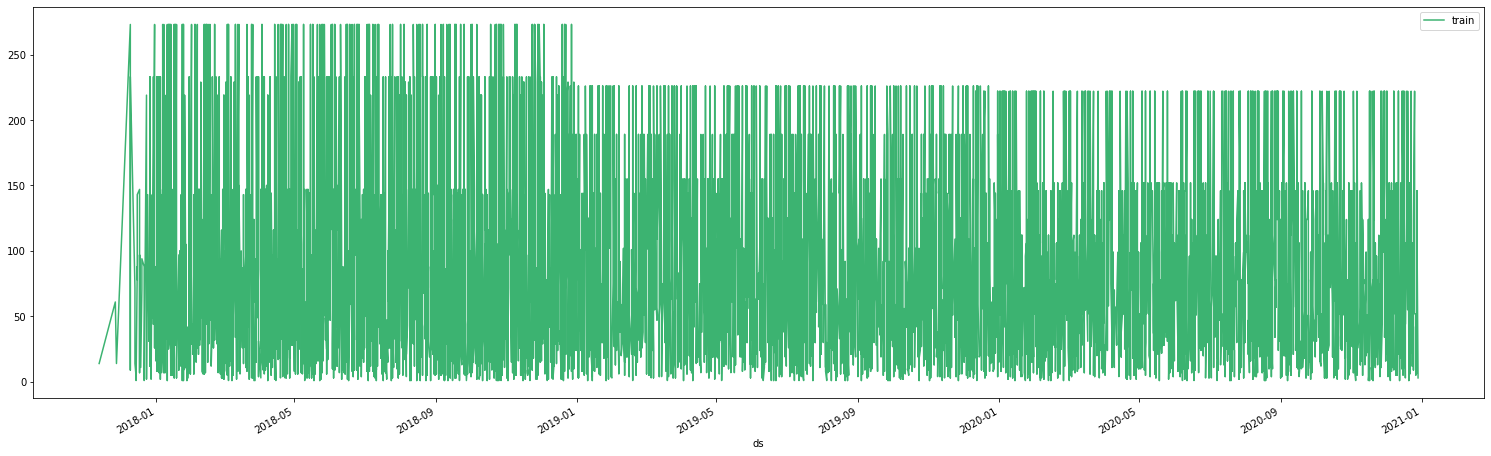

In [130]:
train_final.plot(x='ds', y = 'y',figsize=(26,8), label='train', c='mediumseagreen')
plt.legend()

In [59]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [77]:
pro = Prophet()
pro.fit(train_final)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
future = pro.make_future_dataframe(periods=600)
future.tail()

ds
1698 2022-08-17
1699 2022-08-18
1700 2022-08-19
1701 2022-08-20
1702 2022-08-21

In [83]:
forecast = pro.predict(future)

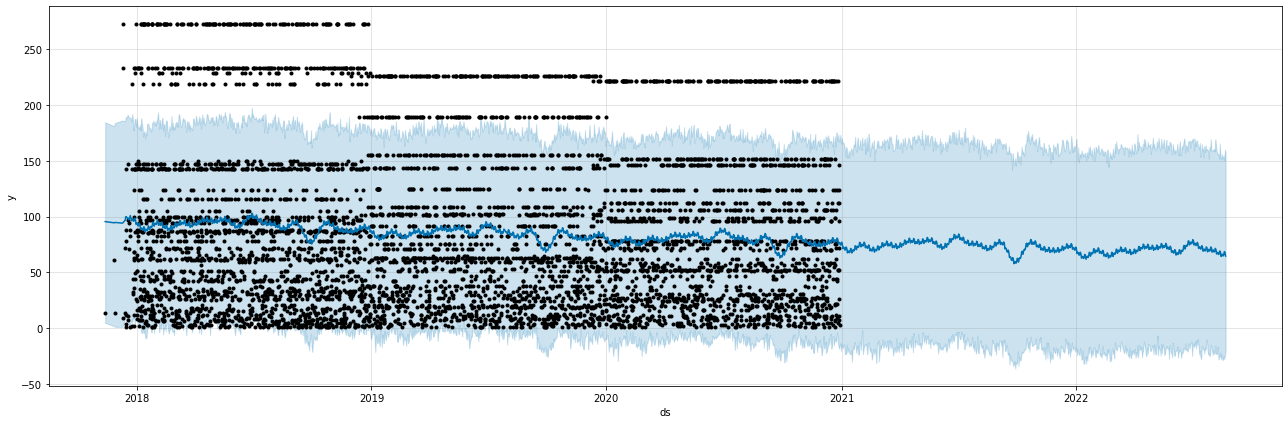

In [87]:
fig1 = pro.plot(forecast,figsize=(18,6))

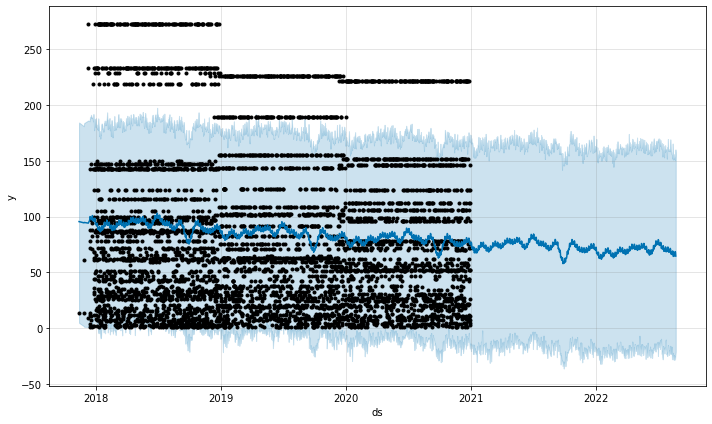

In [88]:
fig1 = pro.plot(forecast,figsize=(10,6))

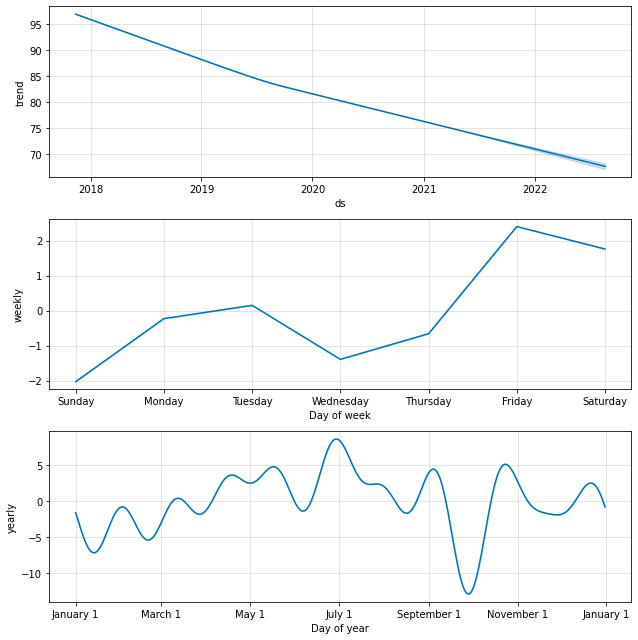

In [89]:
fig1 = pro.plot_components(forecast)

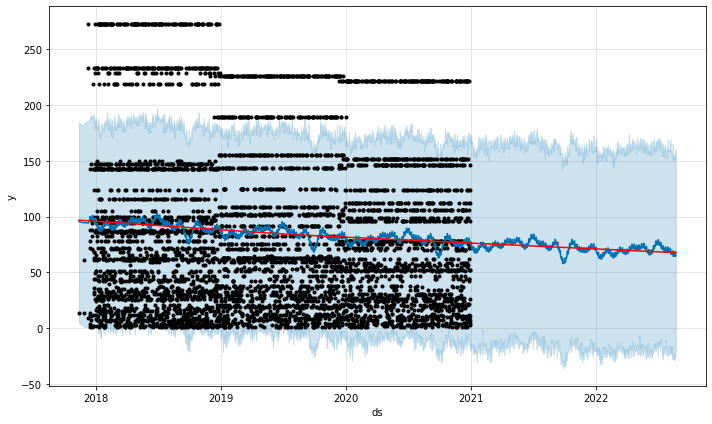

In [90]:
from fbprophet.plot import add_changepoints_to_plot
fig = pro.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro, forecast)

In [91]:
pro.changepoints

184    2018-01-21
369    2018-02-22
553    2018-03-26
738    2018-04-26
922    2018-05-25
1107   2018-06-29
1291   2018-07-28
1476   2018-08-30
1660   2018-10-01
1844   2018-10-30
2029   2018-11-30
2213   2019-01-02
2398   2019-02-02
2582   2019-03-07
2767   2019-04-13
2951   2019-05-22
3135   2019-07-01
3320   2019-08-12
3504   2019-09-20
3689   2019-10-29
3873   2019-12-04
4058   2020-01-10
4242   2020-02-13
4427   2020-03-21
4611   2020-04-29
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


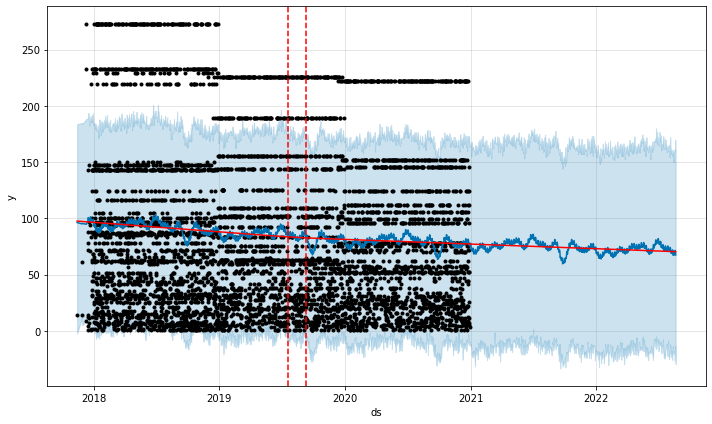

In [98]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_final).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


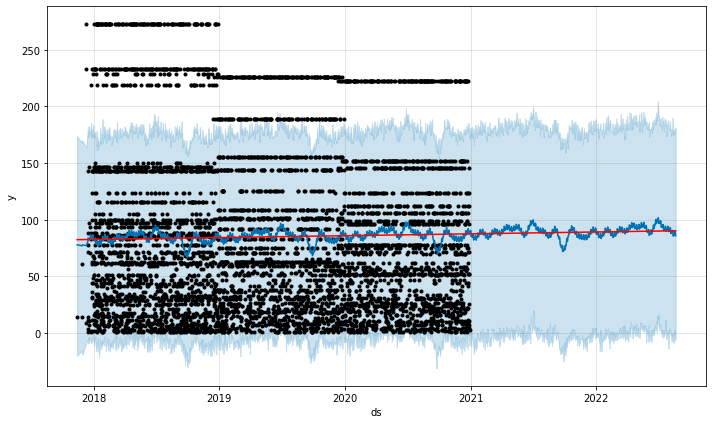

In [118]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(train_final).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [119]:
train_final['age-group'] = X['age-group']
train_X= train_final[:4000]
test_X= train_final[4000:]

In [120]:
test_X

ds    y  age-group
4000 2018-01-03  233         18
4001 2018-01-05  233         18
4002 2018-01-08  233         18
4003 2017-12-30  233         18
4004 2018-01-18  233         18
...         ...  ...        ...
5760 2020-07-08    1         13
5761 2018-01-19    3         15
5762 2018-09-05    5         17
5763 2019-01-28    2         15
5764 2020-11-17    1         12

[1765 rows x 3 columns]

In [121]:
pro_regressor= Prophet()
pro_regressor.add_regressor('age-group')

In [122]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


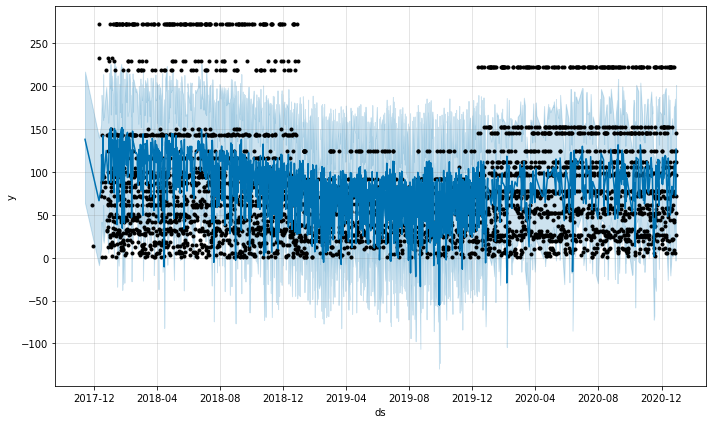

In [123]:
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);


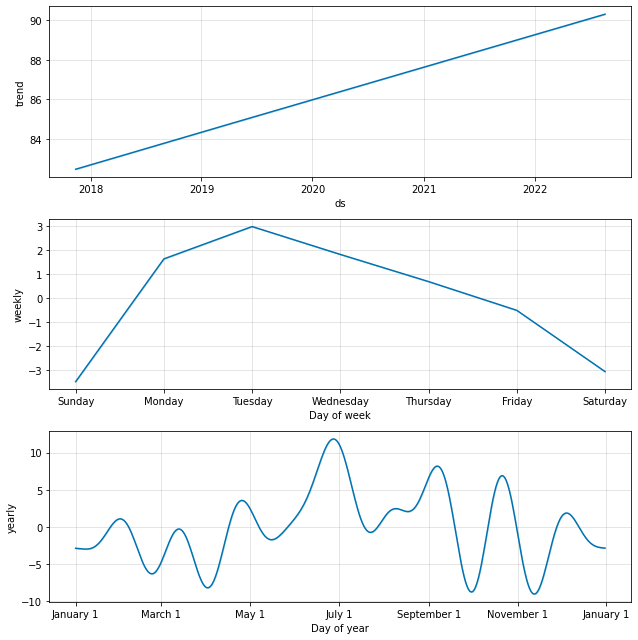

In [124]:
fig2 = pro_regressor.plot_components(forecast)

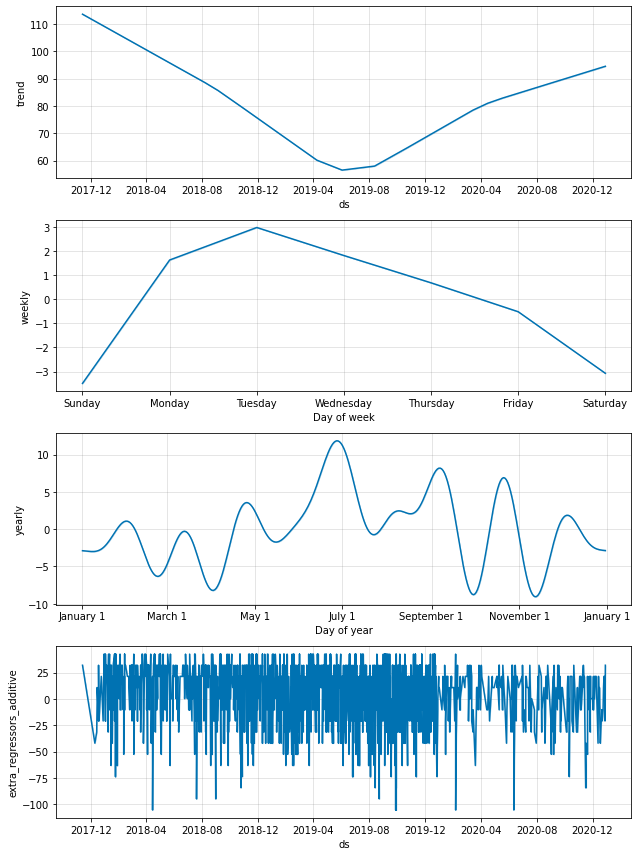

In [125]:
fig3 = pro_regressor.plot_components(forecast_data)

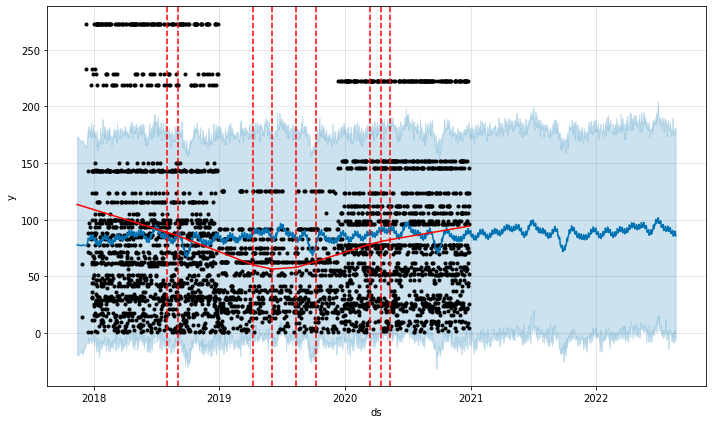

In [126]:
fig4 = pro_regressor.plot(forecast)
a = add_changepoints_to_plot(fig4.gca(), pro_regressor, forecast_data)